# 1. 데이터 로드 및 전처리

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

In [18]:


# Let's load the uploaded CSV file and inspect the first few rows to understand its structure.
file_path = '/content/bank.csv'
data = pd.read_csv(file_path)
data_raw = data.copy()

In [19]:

# Step 1: Preprocessing
# Encode the categorical variables
print(data.columns)


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')


In [20]:
data.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


## 범주형데이터 전처리

In [21]:

label_encoders = {}
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

## 수치형 데이터 전처리

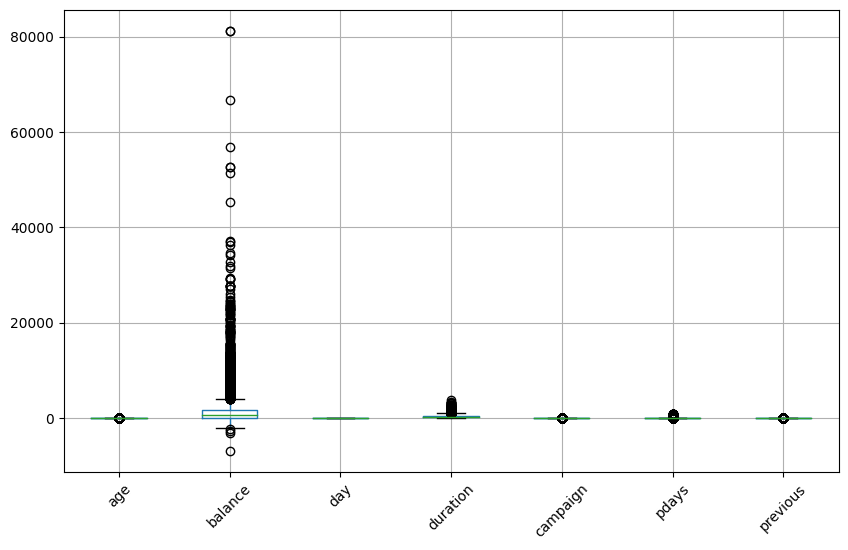

In [22]:
plt.figure(figsize=(10, 6))
data_raw.boxplot(column=numerical_columns)
plt.xticks(rotation=45)
plt.show()

In [23]:
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
numerical_columns_log = ['balance', 'duration', 'campaign', 'pdays', 'previous']
# Apply log transformation
# Add a small constant to avoid log(0) issues if necessary
for col in numerical_columns_log:
    # Check for negative values and replace them with a small positive value before log transformation
    data[col] = data[col].apply(lambda x: np.log1p(x) if x >= 0 else np.nan)  # log1p is equivalent to log(1 + x)



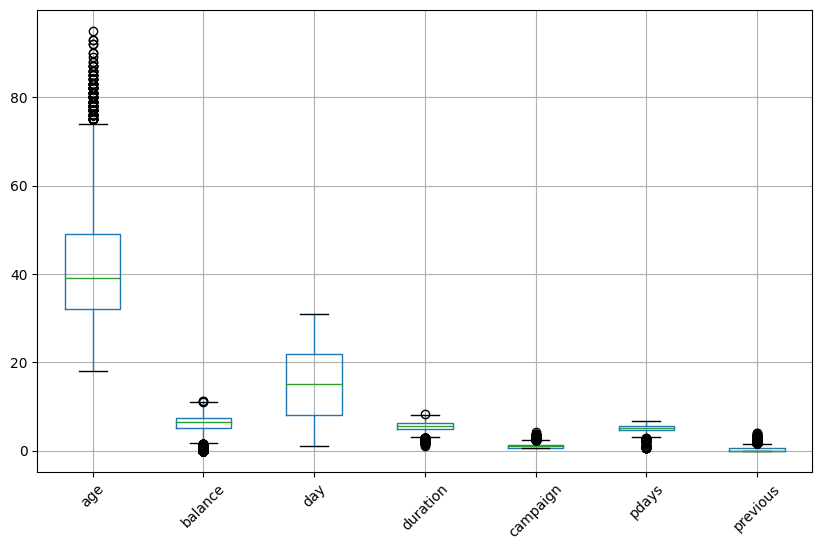

In [24]:
plt.figure(figsize=(10, 6))
data.boxplot(column=numerical_columns)
plt.xticks(rotation=45)
plt.show()

In [25]:
def remove_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the outlier removal for each numerical column
for col in numerical_columns:
    data = remove_outliers_iqr(data, col)

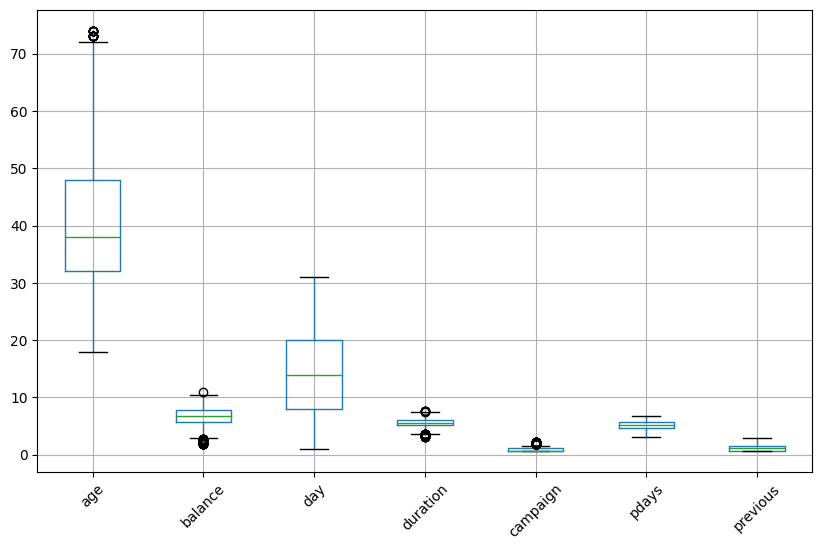

In [26]:
plt.figure(figsize=(10, 6))
data.boxplot(column=numerical_columns)
plt.xticks(rotation=45)
plt.show()

In [27]:
scaler = MinMaxScaler()
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
# age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
# job, marital, education, default, housing, loan, contact,  month, poutcome

data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
# data[numerical_columns] = scaler.transform(data[numerical_columns])

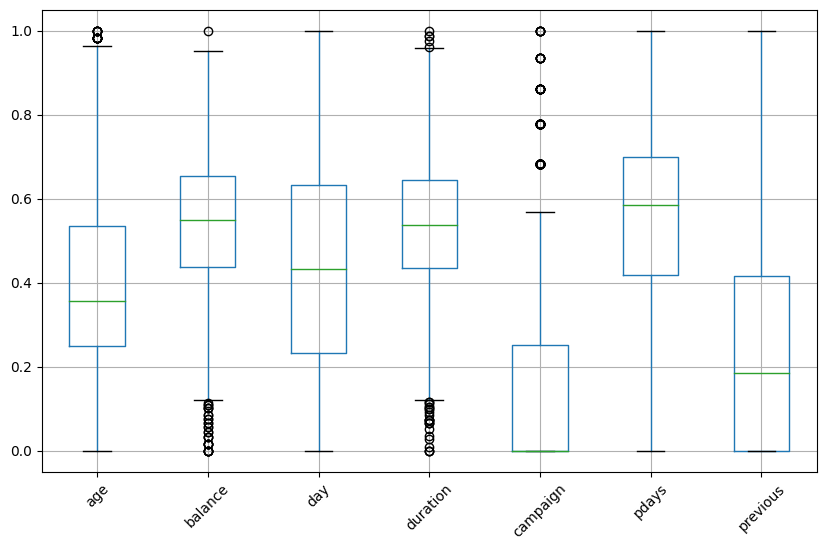

In [28]:
plt.figure(figsize=(10, 6))
data.boxplot(column=numerical_columns)
plt.xticks(rotation=45)
plt.show()

In [47]:
# Separate features (X) and target (y)
X = data.drop(columns=['deposit'])  # All features except the target
X = X.drop(columns=['duration'])  # All features except the target

X2 = X[['pdays', 'contact', 'month', 'age', 'campaign']]

y = data['deposit']  # Target variable (whether deposit was made or not)

In [48]:
# 데이터셋을 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42, stratify=y)

# 모델링

### 랜덤포레스트


Test AUC: 0.8904353455251659
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       148
           1       0.85      0.93      0.89       334

    accuracy                           0.84       482
   macro avg       0.83      0.78      0.80       482
weighted avg       0.84      0.84      0.83       482

In [31]:
# 랜덤 포레스트를 위한 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # 트리의 개수
    'max_depth': [10, 15, 20, 25],         # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],       # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]          # 리프 노드에 있어야 하는 최소 샘플 수
}

# 랜덤 포레스트 모델 생성
rf = RandomForestClassifier(random_state=42)

# 그리드 서치를 위한 설정 (교차 검증은 5-fold로 설정)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='roc_auc', verbose=2)

# 그리드 서치를 통한 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# 최적의 모델로 테스트 데이터 예측 및 성능 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# AUC 및 다른 성능 평가 지표 출력
auc = roc_auc_score(y_test, y_prob)
print(f"Test AUC: {auc}")

# 분류 보고서 출력
print(classification_report(y_test, y_pred))



Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}
Test AUC: 0.8269946593299887
              precision    recall  f1-score   support

           0       0.71      0.61      0.66       148
           1       0.84      0.89      0.86       334

    accuracy                           0.80       482
   macro avg       0.78      0.75      0.76       482
weighted avg       0.80      0.80      0.80       482



In [32]:
!pip install optuna

In [33]:
from sklearn.model_selection import cross_val_score
import optuna
def objective(trial):
    # 하이퍼파라미터 범위 정의
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # 랜덤 포레스트 모델 정의
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # 교차 검증으로 AUC 계산
    auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()

    return auc

# Optuna로 하이퍼파라미터 최적화 수행
study = optuna.create_study(direction='maximize')  # AUC를 최대로 하는 방향으로 설정
study.optimize(objective, n_trials=50)  # 50번의 실험을 수행

# 최적의 하이퍼파라미터 출력
best_params = study.best_params
print(f"Best parameters: {best_params}")

# 최적 하이퍼파라미터로 모델 학습
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# 테스트 데이터로 예측 및 평가
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

print(f"Test AUC: {auc}")

[I 2024-09-20 00:24:09,521] A new study created in memory with name: no-name-81921e81-bc40-46ca-9e1f-368960fa08ea
[I 2024-09-20 00:24:10,952] Trial 0 finished with value: 0.8217998225761451 and parameters: {'n_estimators': 122, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8217998225761451.
[I 2024-09-20 00:24:11,800] Trial 1 finished with value: 0.8264192974847528 and parameters: {'n_estimators': 60, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8264192974847528.
[I 2024-09-20 00:24:12,789] Trial 2 finished with value: 0.8224340888516901 and parameters: {'n_estimators': 82, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8264192974847528.
[I 2024-09-20 00:24:16,810] Trial 3 finished with value: 0.8238660156502136 and parameters: {'n_estimators': 294, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 

Best parameters: {'n_estimators': 232, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 1}
Test AUC: 0.8272171872471273


### 앙상블

In [34]:
# 필요한 라이브러리 임포트
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.svm import SVC

# 각 개별 모델 생성
log_clf = LogisticRegression(random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(probability=True, random_state=42)  # SVM도 추가하고 확률 예측 사용을 위해 probability=True 설정

# 투표 앙상블 모델 생성 (소프트 보팅 사용)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rf_clf), ('gb', gb_clf), ('svm', svm_clf)],
    voting='soft'  # 소프트 보팅 사용
)

# 투표 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = voting_clf.predict(X_test)
y_prob = voting_clf.predict_proba(X_test)[:, 1]

# AUC 및 다른 성능 평가 지표 출력
auc = roc_auc_score(y_test, y_prob)
print(f"Test AUC: {auc}")

# 분류 보고서 출력
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test AUC: 0.8198535361709014
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       148
           1       0.83      0.90      0.86       334

    accuracy                           0.80       482
   macro avg       0.77      0.73      0.75       482
weighted avg       0.79      0.80      0.79       482




Test AUC: 0.8842854830878782
              precision    recall  f1-score   support

           0       0.79      0.59      0.68       148
           1       0.84      0.93      0.88       334

    accuracy                           0.83       482
   macro avg       0.81      0.76      0.78       482
weighted avg       0.82      0.83      0.82       482

### 스태킹

In [40]:
# 필요한 라이브러리 임포트
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV

# 베이스 모델들 생성
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# 메타 모델 생성 (스태킹의 최종 단계에서 사용할 모델)
meta_learner = LogisticRegression()

# 스태킹 앙상블 생성
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5
)

# 스태킹 모델 학습
stacking_clf.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = stacking_clf.predict(X_test)
y_prob = stacking_clf.predict_proba(X_test)[:, 1]

# AUC 및 다른 성능 평가 지표 출력
auc = roc_auc_score(y_test, y_prob)
print(f"Test AUC: {auc}")

# 분류 보고서 출력
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:29:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:30:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:30:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:30:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:30:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Test AUC: 0.8324769380158601
              precision    recall  f1-score   support

           0       0.73      0.59      0.65       148
           1       0.83      0.90      0.87       334

    accuracy                           0.81       482
   macro avg       0.78      0.75      0.76       482
weighted avg       0.80      0.81      0.80       482



Test AUC: 0.8938946431461401
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       148
           1       0.86      0.93      0.90       334

    accuracy                           0.85       482
   macro avg       0.84      0.80      0.81       482
weighted avg       0.85      0.85      0.85       482


In [42]:
# 필요한 라이브러리 임포트
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 하이퍼파라미터 그리드 설정
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_lgb = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1]
}

# 그리드 서치를 통한 최적화
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf = RandomForestClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)

# XGBoost 최적화
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

# RandomForest 최적화
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# LightGBM 최적화
grid_search_lgb = GridSearchCV(lgb, param_grid_lgb, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search_lgb.fit(X_train, y_train)
best_lgb = grid_search_lgb.best_estimator_

# 최적화된 모델들을 스태킹 앙상블에 결합
stacking_clf = StackingClassifier(
    estimators=[('xgb', best_xgb), ('rf', best_rf), ('lgb', best_lgb)],
    final_estimator=LogisticRegression(),
    cv=5
)

# 스태킹 모델 학습
stacking_clf.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = stacking_clf.predict(X_test)
y_prob = stacking_clf.predict_proba(X_test)[:, 1]

# AUC 및 다른 성능 평가 지표 출력
auc = roc_auc_score(y_test, y_prob)
print(f"Test AUC: {auc}")

# 분류 보고서 출력
print(classification_report(y_test, y_pred))


ModuleNotFoundError: No module named 'lightgbm'

Test AUC: 0.8942587797378216
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       148
           1       0.87      0.93      0.90       334

    accuracy                           0.85       482
   macro avg       0.84      0.80      0.82       482
weighted avg       0.85      0.85      0.85       482


## 변수선택


### 랜덤포레스트의 변수중요도

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

# 1. 랜덤 포레스트를 사용하여 특성 중요도 기반 변수 선택
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 특성 중요도 기반 선택 (중요도가 중간 이상인 특성 선택)
selector = SelectFromModel(rf, threshold='median')  # 중요도가 중간 이상인 특성 선택
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_train_selected.shape[1]}")

# 2. 그리드 서치를 통한 최적의 하이퍼파라미터 찾기
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid,
                              cv=5,
                              scoring='roc_auc',
                              n_jobs=-1,
                              verbose=2)
grid_search_rf.fit(X_train_selected, y_train)

# 최적의 하이퍼파라미터로 모델 학습 및 평가
best_rf = grid_search_rf.best_estimator_
y_pred = best_rf.predict(X_test_selected)
y_prob = best_rf.predict_proba(X_test_selected)[:, 1]

# AUC 및 성능 평가
auc = roc_auc_score(y_test, y_prob)
print(f"Test AUC with selected features: {auc}")
print(classification_report(y_test, y_pred))


Original number of features: 15
Reduced number of features: 8
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test AUC with selected features: 0.8276015536494579
              precision    recall  f1-score   support

           0       0.67      0.60      0.64       148
           1       0.83      0.87      0.85       334

    accuracy                           0.79       482
   macro avg       0.75      0.74      0.74       482
weighted avg       0.78      0.79      0.78       482



### pca + 랜덤포레스트

In [44]:
from sklearn.decomposition import PCA

# 1. PCA를 사용하여 차원 축소 (설명된 분산이 95%가 될 때까지 주성분 선택)
pca = PCA(n_components=0.95, random_state=42)  # 95%의 분산을 유지하는 주성분 선택
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features (PCA): {X_train_pca.shape[1]}")

# 2. 그리드 서치를 통한 최적의 하이퍼파라미터 찾기
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf_pca = GridSearchCV(RandomForestClassifier(random_state=42),
                                  param_grid,
                                  cv=5,
                                  scoring='roc_auc',
                                  n_jobs=-1,
                                  verbose=2)
grid_search_rf_pca.fit(X_train_pca, y_train)

# 최적의 하이퍼파라미터로 모델 학습 및 평가
best_rf_pca = grid_search_rf_pca.best_estimator_
y_pred_pca = best_rf_pca.predict(X_test_pca)
y_prob_pca = best_rf_pca.predict_proba(X_test_pca)[:, 1]

# AUC 및 성능 평가
auc_pca = roc_auc_score(y_test, y_prob_pca)
print(f"Test AUC with PCA features: {auc_pca}")
print(classification_report(y_test, y_pred_pca))


Original number of features: 15
Reduced number of features (PCA): 4
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Test AUC with PCA features: 0.777027027027027
              precision    recall  f1-score   support

           0       0.65      0.53      0.59       148
           1       0.81      0.87      0.84       334

    accuracy                           0.77       482
   macro avg       0.73      0.70      0.71       482
weighted avg       0.76      0.77      0.76       482



In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

# 1. 그리드 서치를 통한 랜덤 포레스트 최적의 하이퍼파라미터 찾기
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리의 수
    'max_depth': [10, 20, 30, None],  # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],  # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],    # 리프 노드에 있어야 하는 최소 샘플 수
    'max_features': ['auto', 'sqrt', 'log2']  # 각 노드에서 고려할 최대 특성 수
}

# 그리드 서치로 랜덤 포레스트 모델 최적화
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

# 그리드 서치로 최적의 랜덤 포레스트 모델 찾기
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

print(f"Best Hyperparameters: {grid_search_rf.best_params_}")

# 2. 최적화된 랜덤 포레스트를 사용하여 특성 중요도 기반 변수 선택
selector = SelectFromModel(best_rf, threshold='median')  # 최적화된 모델로 선택
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_train_selected.shape[1]}")

# 3. 선택된 변수를 사용하여 최적화된 랜덤 포레스트로 모델 학습 및 평가
# 최적화된 랜덤 포레스트로 학습
best_rf.fit(X_train_selected, y_train)
y_pred = best_rf.predict(X_test_selected)
y_prob = best_rf.predict_proba(X_test_selected)[:, 1]

# AUC 및 성능 평가
auc = roc_auc_score(y_test, y_prob)
print(f"Test AUC with selected features: {auc}")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
257 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Original number of features: 15
Reduced number of features: 8


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test AUC with selected features: 0.833953714193235
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       148
           1       0.84      0.88      0.86       334

    accuracy                           0.80       482
   macro avg       0.77      0.75      0.76       482
weighted avg       0.79      0.80      0.80       482



In [49]:
# 랜덤 포레스트를 위한 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # 트리의 개수
    'max_depth': [10, 15, 20, 25],         # 트리의 최대 깊이
    'min_samples_split': [2, 5, 10],       # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]          # 리프 노드에 있어야 하는 최소 샘플 수
}

# 랜덤 포레스트 모델 생성
rf = RandomForestClassifier(random_state=42)

# 그리드 서치를 위한 설정 (교차 검증은 5-fold로 설정)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='roc_auc', verbose=2)

# 그리드 서치를 통한 학습
grid_search.fit(X2_train, y2_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# 최적의 모델로 테스트 데이터 예측 및 성능 평가
best_model = grid_search.best_estimator_
y2_pred = best_model.predict(X2_test)
y2_prob = best_model.predict_proba(X2_test)[:, 1]

# AUC 및 다른 성능 평가 지표 출력
auc = roc_auc_score(y2_test, y2_prob)
print(f"Test AUC: {auc}")

# 분류 보고서 출력
print(classification_report(y2_test, y2_pred))



Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Test AUC: 0.7897920375465285
              precision    recall  f1-score   support

           0       0.66      0.59      0.62       148
           1       0.83      0.87      0.85       334

    accuracy                           0.78       482
   macro avg       0.74      0.73      0.73       482
weighted avg       0.77      0.78      0.78       482



Test AUC with selected features: 0.8926403948859039
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       148
           1       0.85      0.93      0.89       334

    accuracy                           0.84       482
   macro avg       0.83      0.78      0.80       482
weighted avg       0.84      0.84      0.83       482

89의 늪.....아....